In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import PyMieScatt as ps
import subprocess
import math
import sys
import pandas as pd
import xgboost as xgb
import sklearn

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from scipy.optimize import root
indreal, indimg, sig = 1.33, 1E-9, 1.8 # ne pas modifier pour l'instant

lw, ms = 1, 0.02

particle_name = 'water-sigma1.8bae'

def BAE_lognormal_fn(diam, sig, indreal, indimg) :
    Q_1064= ps.Mie_Lognormal(complex(indreal,indimg),1064,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_532=ps.Mie_Lognormal(complex(indreal,indimg),532,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_355=ps.Mie_Lognormal(complex(indreal,indimg),355,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 

    BAE_1064_532 = -np.log(Q_1064['Bback']/ Q_532['Bback'])/np.log(1064/532)
    BAE_532_355 = -np.log(Q_532['Bback']/ Q_355['Bback'])/np.log(532/355)
    BAE_1064_355 = -np.log(Q_1064['Bback']/ Q_355['Bback'])/np.log(1064/355)

    return BAE_1064_532, BAE_532_355, BAE_1064_355

In [2]:
# Importation des données (Calculé par le GMM, ne pas oublier de télécharger les fichiers csv)
df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

#définitions du jeu de données pour les différents modèles
diam_entree = df_diam[0:714] # Charger les données diamètre

BAE_1064_532 = df_BAE[0:714,0] #On rogne à 715 points car au dessus d'un diamètres de 10^4 cela n'a plus d'intérêt
BAE_532_355 = df_BAE[0:714,1]
BAE_1064_355 = df_BAE[0:714,2]
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T

In [9]:
# Importation des données (Calculé par le GMM, ne pas oublier de télécharger les fichiers csv)
df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

#définitions du jeu de données pour les différents modèles
diam_entree = df_diam[0:714] # Charger les données diamètre

sig_norm = 0.01 # Sigma de notre bruit gaussien

BAE_1064_532 = df_BAE[0:714,0] + np.random.normal(0, sig_norm, 714)
BAE_532_355 = df_BAE[0:714,1] + np.random.normal(0, sig_norm, 714)
BAE_1064_355 = df_BAE[0:714,2] + np.random.normal(0, sig_norm, 714)
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T

In [ ]:
diam_data = np.array(pd.read_csv("Datasheet/diam_entree.csv"))

indreal = [1.33, 1.385, 1.44, 1.495, 1.55]
indimg = [0.001, 0.00075025, 0.0005005, 0.00025075, 1e-06]
sig = [1.6, 1.7, 1.8, 1.9, 2.0]
Data = np.zeros(shape=(5, 5, 5, 99, 3))

for idx_i, i in enumerate(indreal):
    for idx_j, j in enumerate(indimg):
        for idx_k, k in enumerate(sig):
            filename = f"Datasheet/BAE_sortie_real_{i}_im_{j}_sig_{k}.csv"
            BAE_data = np.array(pd.read_csv(filename, delimiter=","))
            Data[idx_i, idx_j, idx_k] = BAE_data

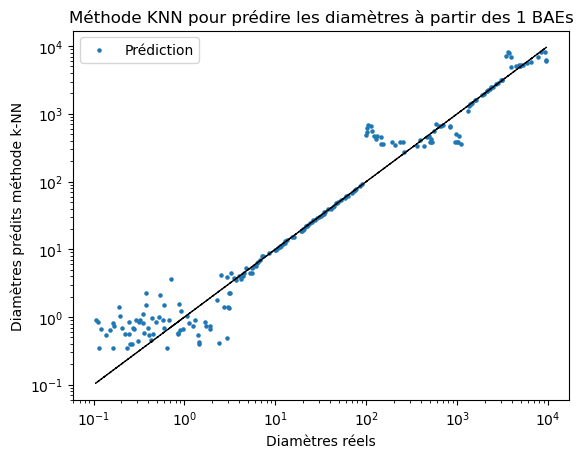

In [10]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
diam_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, diam_pred)

# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_1 = end-start

mse_1 = mean_squared_error(y_test, diam_pred)
r2_1 = r2_score(y_test, diam_pred)
mae_1 = mean_absolute_error(y_test, diam_pred)
tcap_1 = np.mean(np.abs((y_test - diam_pred) / y_test + 0.01))

# Afficher les résultats de la régression KNN
plt.scatter(y_test, diam_pred, s=5, label="Prédiction")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits méthode k-NN')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Méthode KNN pour prédire les diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

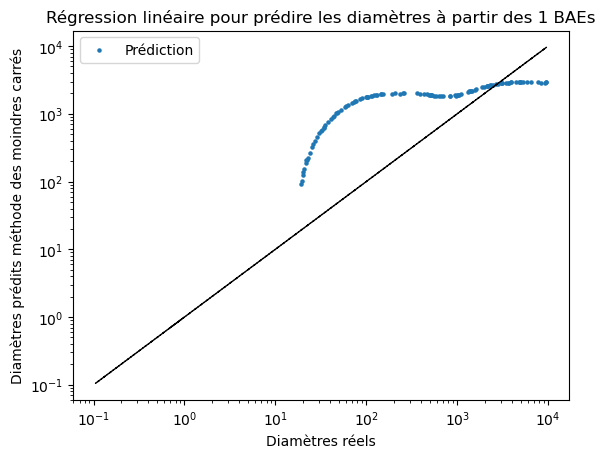

In [11]:
# Séparation des données en train et test
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entrainer le modèle de régression linéaire
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)

# Prédire les valeurs de diamètres en utilisant le modèle de régression linéaire
diam_pred = reg_lin.predict(X_test)

# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_2 = end-start

mse_2 = mean_squared_error(y_test, diam_pred)
r2_2 = r2_score(y_test, diam_pred)
mae_2 = mean_absolute_error(y_test, diam_pred)
tcap_2 = np.mean(np.abs((y_test - diam_pred) / y_test + 0.01))

# Afficher les résultats de la régression linéaire
plt.scatter(y_test, diam_pred, s=5, label="Prédiction")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits méthode des moindres carrés')
plt.title('Régression linéaire pour prédire les diamètres à partir des 1 BAEs')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.legend()
plt.show()


C:\Users\thoma\AppData\Local\Temp\ipykernel_11356\1027746685.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


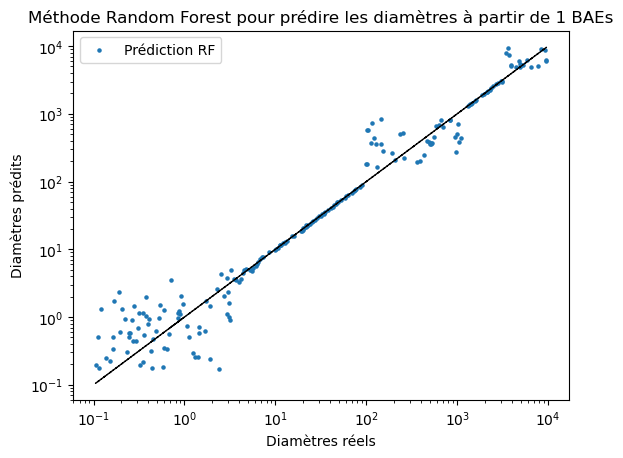

In [12]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
diam_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, diam_pred)

# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_3 = end-start

mse_3 = mean_squared_error(y_test, diam_pred)
r2_3 = r2_score(y_test, diam_pred)
mae_3 = mean_absolute_error(y_test, diam_pred)
tcap_3 = np.mean(np.abs((y_test - diam_pred) / y_test + 0.01))

# Afficher les résultats de la régression Random Forest
plt.scatter(y_test, diam_pred, s=5, label="Prédiction RF")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Méthode Random Forest pour prédire les diamètres à partir de 1 BAEs')
plt.legend()
plt.show()

MSE pour les prédictions combinées: 427993.11, R² pour les prédictions combinées: 0.86


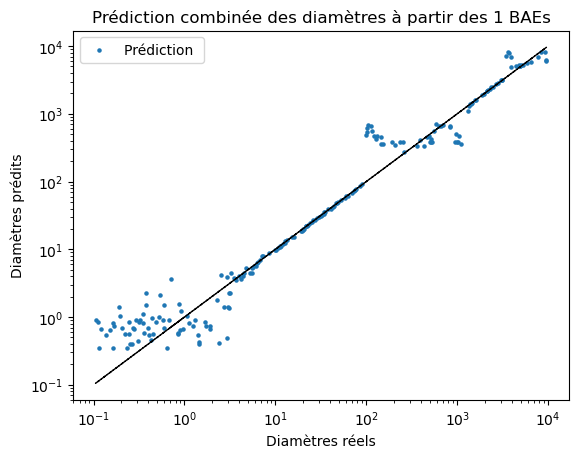

In [13]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn1 = KNeighborsRegressor(n_neighbors=10)
knn1.fit(X_train1, y_train1)
diam_pred1 = knn1.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la deuxième partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train2, y_train2)
diam_pred2 = reg_lin.predict(X_test2)

# Combiner les prédictions des deux modèles en concaténant les tableaux de prédictions
diam_pred = np.concatenate((diam_pred1[:3000], diam_pred2[3000:5000], diam_pred1[5000:]), axis=0)
y_test =  np.concatenate((y_test1[:3000], y_test2[3000:5000], y_test1[5000:]), axis=0)

# Calcul de l'erreur MSE et R² pour les prédictions combinées
mse = mean_squared_error(y_test, diam_pred)
r2 = r2_score(y_test, diam_pred)
print("MSE pour les prédictions combinées: {:.2f}, R² pour les prédictions combinées: {:.2f}".format(mse, r2))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_test1, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.legend()
plt.show()


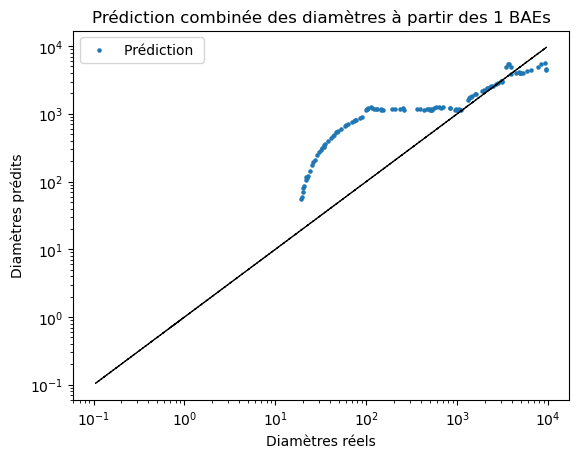

In [14]:
start =time.time()
# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn1 = KNeighborsRegressor(n_neighbors=10)
knn1.fit(X_train1, y_train1)

# Faire les prédictions pour la première partie des données
diam_pred1 = knn1.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la deuxième partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train2, y_train2)

# Faire les prédictions pour la deuxième partie des données
diam_pred2 = reg_lin.predict(X_test2)


# Faire les prédictions avec les deux modèles
diam_pred1 = knn1.predict(X_test)
diam_pred2 = reg_lin.predict(X_test)

# Calculer la moyenne des prédictions des deux modèles
diam_pred = (diam_pred1 + diam_pred2) / 2

# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_4 = end-start

mse_4 = mean_squared_error(y_test, diam_pred)
r2_4 = r2_score(y_test, diam_pred)
mae_4 = mean_absolute_error(y_test, diam_pred)
tcap_4 = np.mean(np.abs((y_test - diam_pred) / y_test + 0.01))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_test1, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

MSE pour les prédictions combinées: 358442.56, R² pour les prédictions combinées: 0.79


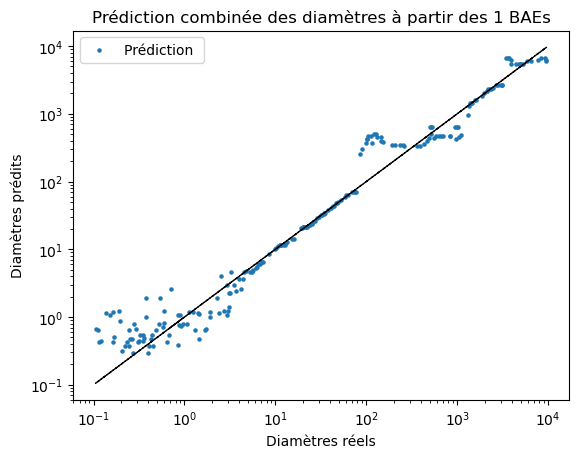

In [15]:
# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn1 = KNeighborsRegressor(n_neighbors=10)
knn1.fit(X_train1, y_train1)
diam_pred1 = knn1.predict(X_test1)

# Instancier et entraîner le modèle KNN pour la deuxième partie des données
knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(X_train2, y_train2)
diam_pred2 = knn2.predict(X_test2)

# Instancier et entraîner un modèle de régression linéaire pour la première partie des données
reg_lin1 = LinearRegression()
reg_lin1.fit(X_train1, y_train1)
diam_pred3 = reg_lin1.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la deuxième partie des données
reg_lin2 = LinearRegression()
reg_lin2.fit(X_train2, y_train2)
diam_pred4 = reg_lin2.predict(X_test2)

# Combiner les prédictions des deux modèles en utilisant la méthode stacking
X_stack = np.column_stack((diam_pred1, diam_pred2, diam_pred3, diam_pred4))
y_stack = y_test1.reshape(-1, 1)

knn_stack = KNeighborsRegressor(n_neighbors=10)
knn_stack.fit(X_stack, y_stack)
diam_pred_stack = knn_stack.predict(X_stack)

# Calcul de l'erreur MSE et R² pour les prédictions combinées
mse = mean_squared_error(y_stack, diam_pred_stack)
r2 = r2_score(y_stack, diam_pred)
print("MSE pour les prédictions combinées: {:.2f}, R² pour les prédictions combinées: {:.2f}".format(mse, r2))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_stack, diam_pred_stack, s=5, label="Prédiction ")
plt.plot(y_test1, y_test1, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_11356\1158181305.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\thoma\AppData\Local\Temp\ipykernel_11356\1158181305.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ensemble_pred = ensemble_model.predict(np.column_stack((model.predict(X_test) for model in models)))


MSE pour les prédictions combinées: 500968.21, R² pour les prédictions combinées: 0.84


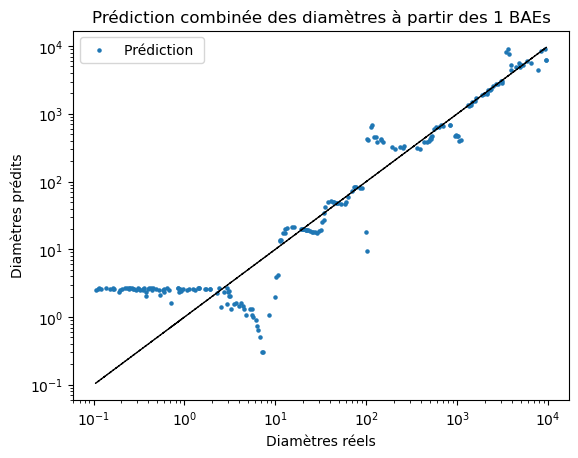

In [17]:
# Diviser les données en ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Définir une liste de modèles à utiliser
models = [KNeighborsRegressor(n_neighbors=10),
              RandomForestRegressor(n_estimators=100, max_depth=5)]

# Stocker les prédictions de chaque modèle dans une matrice
pred_matrix = np.empty((len(X_train), 0))
for model in models:
    model.fit(X_train, y_train)
    pred_matrix = np.column_stack((pred_matrix, model.predict(X_train)))

# Entraîner un modèle d'ensemble sur les prédictions
ensemble_model = LinearRegression()
ensemble_model.fit(pred_matrix, y_train)

# Effectuer des prédictions sur l'ensemble de test en utilisant le modèle d'ensemble entraîné
ensemble_pred = ensemble_model.predict(np.column_stack((model.predict(X_test) for model in models)))

# Évaluer les performances du modèle en utilisant l'erreur quadratique moyenne (MSE) et le coefficient de détermination (R²)
mse = mean_squared_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)
print("MSE pour les prédictions combinées: {:.2f}, R² pour les prédictions combinées: {:.2f}".format(mse, r2))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_test, ensemble_pred, s=5, label="Prédiction ")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

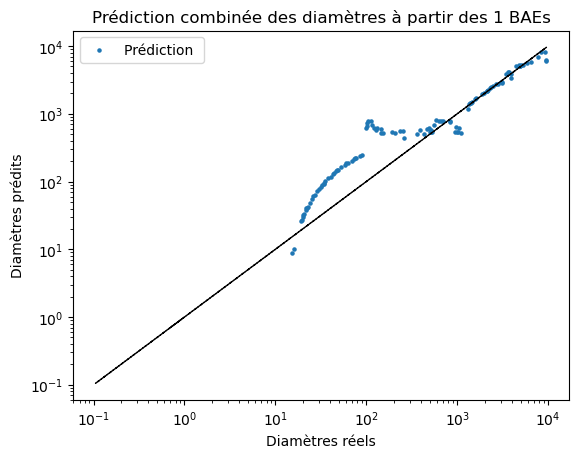

In [18]:
start = time.time()
# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train1, y_train1)
diam_pred1 = knn.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la première partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train1, y_train1)
diam_pred2 = reg_lin.predict(X_test1)

# Combiner les prédictions des deux modèles en utilisant la méthode de vote pondéré
diam_pred = np.zeros(diam_pred1.shape[0])
for i in range(diam_pred1.shape[0]):
    if y_test1[i] < 2500:
        diam_pred[i] = (0.9 * diam_pred1[i]) + (0.1 * diam_pred2[i])
    elif y_test1[i] < 4200:
        diam_pred[i] = (0.25 * diam_pred1[i]) + (0.75 * diam_pred2[i])
    else:
        diam_pred[i] = diam_pred1[i]
        
# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_5 = end-start

mse_5 = mean_squared_error(y_test1, diam_pred)
r2_5 = r2_score(y_test1, diam_pred)
mae_5 = mean_absolute_error(y_test1, diam_pred)
tcap_5 = np.mean(np.abs((y_test1 - diam_pred) / y_test1 + 0.01))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_test1, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test1, y_test, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

7/7 [==============================] - 0s 827us/step
MSE pour les prédictions combinées: 2580656.16, R² pour les prédictions combinées: 0.17


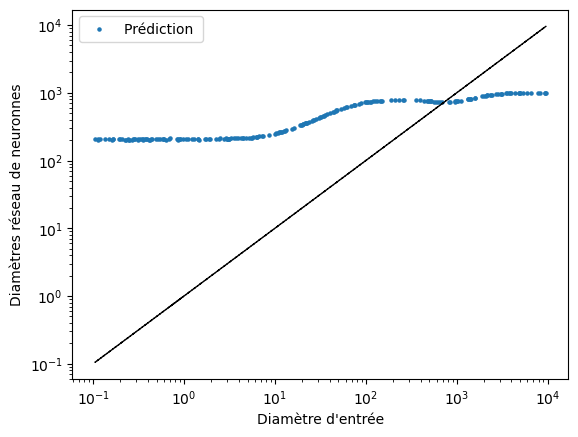

In [19]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Diviser les données en ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Normaliser les données d'entrée
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définir l'architecture du modèle
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1)
])

# Compiler le modèle
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Faire des prédictions sur de nouvelles données
diam_pred = model.predict(X_test)

# Calcul de l'erreur MSE et R² pour les prédictions combinées
mse = mean_squared_error(y_test, diam_pred)
r2 = r2_score(y_test, diam_pred)
print("MSE pour les prédictions combinées: {:.2f}, R² pour les prédictions combinées: {:.2f}".format(mse, r2))

# Tracé des prédictions
plt.scatter(y_test, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test, y_test, 'k--', lw=1,)
plt.xlabel("Diamètre d'entrée")
plt.ylabel("Diamètres réseau de neuronnes")
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.legend()
plt.show()

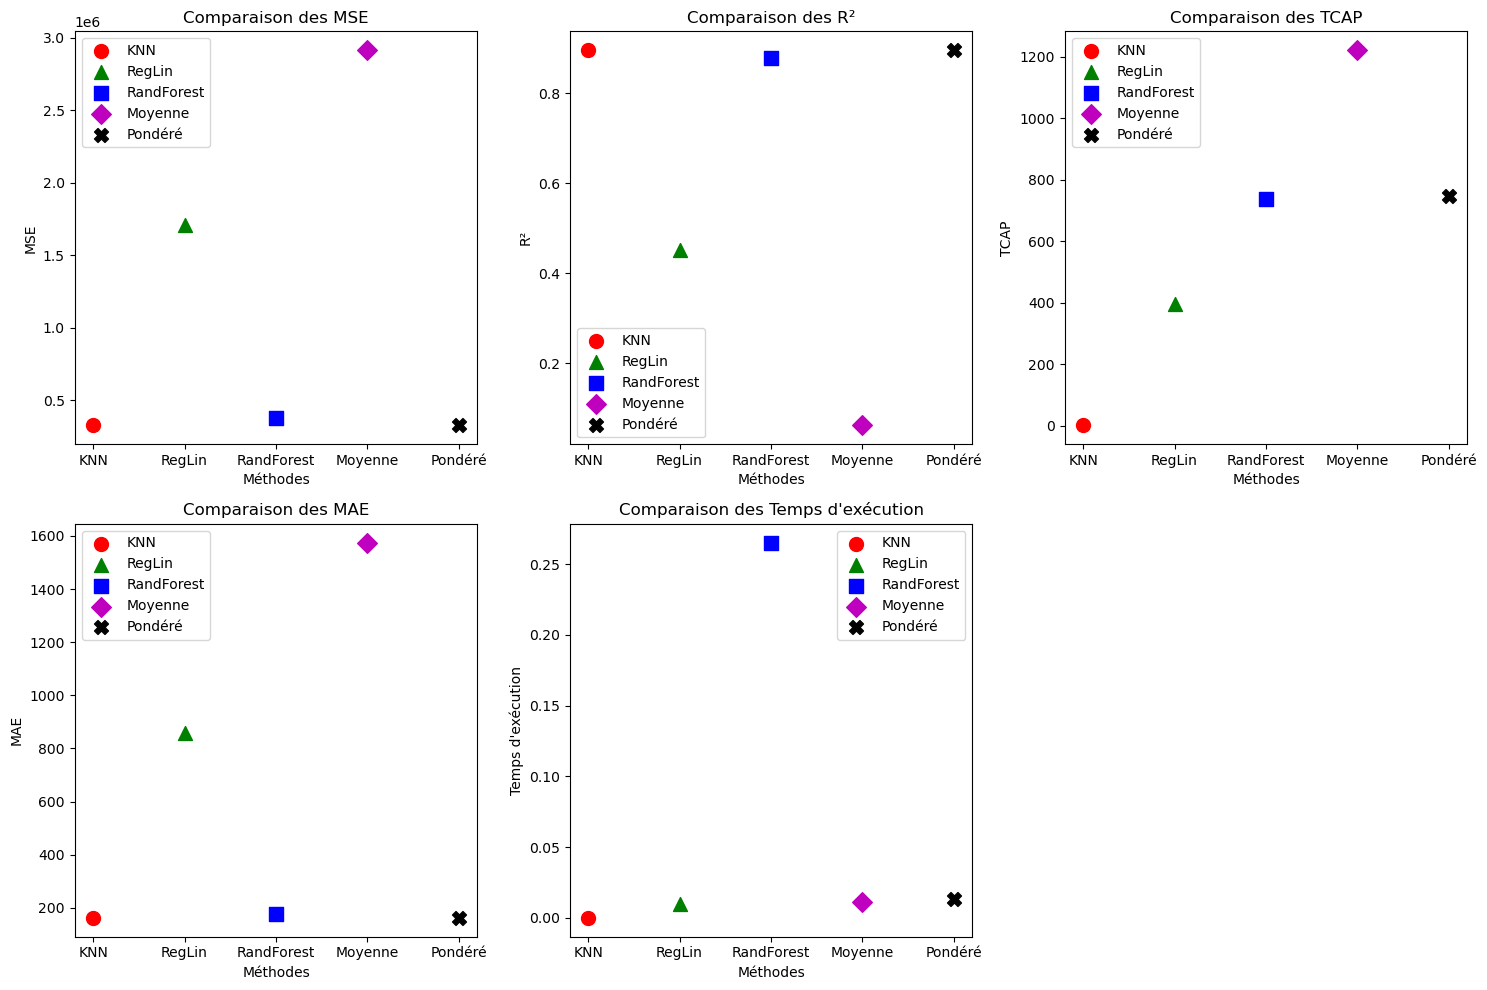

In [31]:
# Stockage des valeurs de MSE et R² dans des listes
mse_values = [mse_1, mse_2, mse_3, mse_4, mse_5]
r2_values = [r2_1, r2_2, r2_3, r2_4, r2_5]
tcap_values = [tcap_1, tcap_2, tcap_3, tcap_4, tcap_5]
mae_values = [mae_1, mae_2, mae_3, mae_4, mae_5]
tmps_values = [tmps_1, tmps_2, tmps_3, tmps_4, tmps_5]

# Graphiques pour les différentes métriques
metrics = ['MSE', 'R2', 'TCAP', 'mae', 'tmps']
names = ['MSE', 'R²', 'TCAP', 'MAE', "Temps d'exécution"]
methods = ['KNN', 'RegLin', 'RandForest', 'Moyenne', 'Pondéré']
markers = ['o', '^', 's', 'D', 'X']
colors = ['red', 'green', 'blue', 'm', 'k']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.ravel()):
    if i < len(metrics):
        for j, method in enumerate(methods):
            ax.scatter(j, eval(metrics[i].lower() + '_values')[j], 
                marker=markers[j], color=colors[j], label=method, s = 100)
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods)
        ax.set_xlabel('Méthodes')
        ax.set_ylabel(names[i])
        ax.set_title(f"Comparaison des {names[i]}")
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()

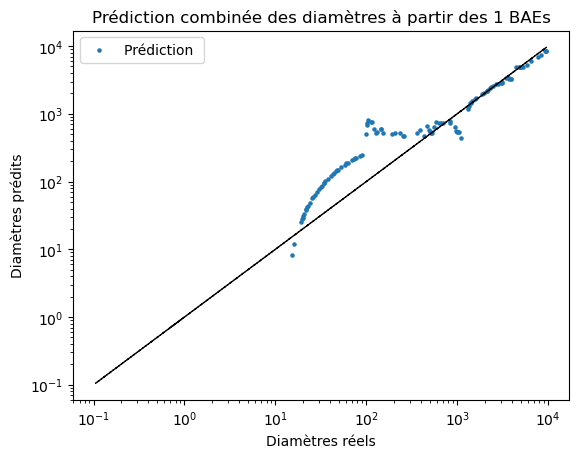

In [25]:
start = time.time()
# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train1, y_train1)
diam_pred1 = knn.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la première partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train1, y_train1)
diam_pred2 = reg_lin.predict(X_test1)

# Combiner les prédictions des deux modèles en utilisant la méthode de vote pondéré
diam_pred = np.zeros(diam_pred1.shape[0])
for i in range(diam_pred1.shape[0]):
    if y_test1[i] < 2500:
        diam_pred[i] = (0.9 * diam_pred1[i]) + (0.1 * diam_pred2[i])
    elif y_test1[i] < 4200:
        diam_pred[i] = (0.1 * diam_pred1[i]) + (0.9 * diam_pred2[i])
    else:
        diam_pred[i] = diam_pred1[i]
        
# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_5 = end-start

mse_5 = mean_squared_error(y_test1, diam_pred)
r2_5 = r2_score(y_test1, diam_pred)
mae_5 = mean_absolute_error(y_test1, diam_pred)
tcap_5 = np.mean(np.abs((y_test1 - diam_pred) / y_test1 + 0.01))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_test1, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test1, y_test1, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

[0.5 0.5 0.5 0.5]


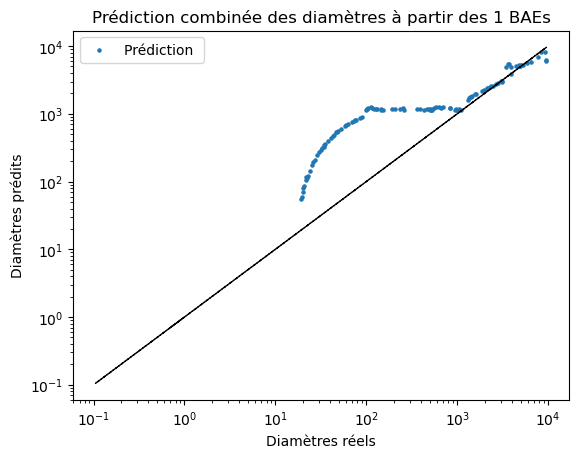

In [20]:
from scipy.optimize import minimize

# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train1, y_train1)
diam_pred1 = knn.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la première partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train1, y_train1)
diam_pred2 = reg_lin.predict(X_test1)

def weighted_mse(weights):
    # Prédire le diamètre en combinant les prédictions des deux modèles avec les poids donnés
    diam_pred = np.zeros(diam_pred1.shape[0])
    for i in range(diam_pred1.shape[0]):
        if y_test1[i] < 2300:
            diam_pred[i] = (weights[0] * diam_pred1[i]) + (weights[1] * diam_pred2[i])
        elif y_test1[i] < 4500:
            diam_pred[i] = (weights[2] * diam_pred1[i]) + (weights[3] * diam_pred2[i])
        else:
            diam_pred[i] = diam_pred1[i]
    # Calculer le MSE des prédictions combinées
    mse = mean_squared_error(y_test1, diam_pred)
    return mse

# Définir les contraintes pour les poids des modèles
cons = ({'type': 'ineq', 'fun': lambda x:  x[0]+x[1]-1},
        {'type': 'ineq', 'fun': lambda x:  x[2]+x[3]-1})

# Définir les bornes des poids des modèles
bnds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Initialiser les poids avec des valeurs égales
init_weights = np.array([0.5, 0.5, 0.5, 0.5])

# Minimiser le MAE en ajustant les poids des modèles
res = minimize(weighted_mse, init_weights, method='SLSQP', bounds=bnds, constraints=cons)

# Récupérer les poids optimaux
opt_weights = res.x
print(opt_weights)

# Combiner les prédictions des deux modèles en utilisant la méthode de vote pondéré
diam_sol = np.zeros(diam_pred1.shape[0])
for i in range(diam_pred1.shape[0]):
    if y_test1[i] < 2300:
        diam_sol[i] = (opt_weights[0] * diam_pred1[i]) + (opt_weights[1] * diam_pred2[i])
    elif y_test1[i] < 4300:
        diam_sol[i] = (opt_weights[2] * diam_pred1[i]) + (opt_weights[3] * diam_pred2[i])
    else:
        diam_sol[i] = diam_pred1[i]


# Afficher les résultats de la prédiction combinée
plt.scatter(y_test1, diam_sol, s=5, label="Prédiction ")
plt.plot(y_test1, y_test1, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()

In [ ]:
def BAE_lognormal_fn_grad(diam, sig, indreal, indimg):
    Q_1064= ps.Mie_Lognormal(complex(indreal,indimg),1064,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_532=ps.Mie_Lognormal(complex(indreal,indimg),532,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_355=ps.Mie_Lognormal(complex(indreal,indimg),355,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 

    BAE_1064_532 = -np.log(Q_1064['Bback']/ Q_532['Bback'])/np.log(1064/532)
    BAE_532_355 = -np.log(Q_532['Bback']/ Q_355['Bback'])/np.log(532/355)
    BAE_1064_355 = -np.log(Q_1064['Bback']/ Q_355['Bback'])/np.log(1064/355)

    return np.array([BAE_1064_532, BAE_532_355, BAE_1064_355])

def grad_BAE(diam, sig, indreal, indimg):
    grad = BAE_lognormal_fn_grad(diam, sig, indreal, indimg)
    return grad[1]  # return the second value of the gradient array

print(grad_BAE(df_diam, sig, indreal, indimg))

#sol = root(grad_BAE, x0=initial_guess, args=(sig, indreal, indimg)) 

In [33]:
opt_weight = np.zeros((len(diam_sign_changes)))
for i in range(len(opt_weight)/2):
    opt_weight[i]=1.0

print(diam_sign_changes)

diam_sign_changes.insert(0,diam_pred[0])   
diam_sign_changes.append(diam_pred[-1])
for i in range(len(diam_sign_changes)-1):
    diam_pred[diam_sign_changes[i]:diam_sign_changes[i+1]] = opt_weight[i]*diam_pred1[diam_sign_changes[i]:diam_sign_changes[i+1]]
    + opt_weights[i+1]*diam_pred[diam_sign_changes[i]:diam_sign_changes[i+1]]

NameError: name 'diam_sign_changes' is not defined

[0.5 0.5 0.5 0.5]


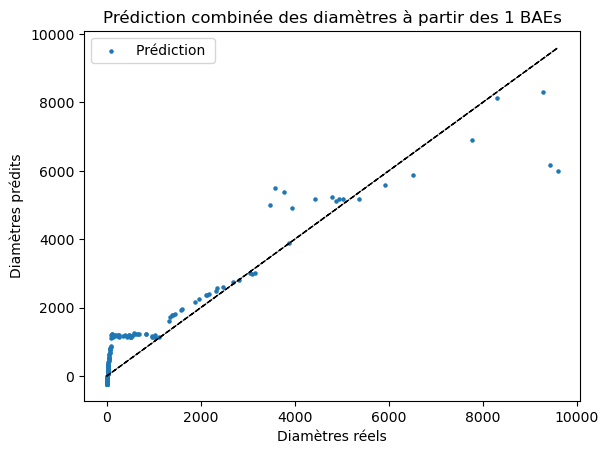

In [21]:
start = time.time()
# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train1, y_train1)
diam_pred1 = knn.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la première partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train1, y_train1)
diam_pred2 = reg_lin.predict(X_test1)

def weighted_mse(weights):
    # Prédire le diamètre en combinant les prédictions des deux modèles avec les poids donnés
    diam_pred = np.zeros(diam_pred1.shape[0])
    for i in range(diam_pred1.shape[0]):
        if y_test1[i] < 2500:
            diam_pred[i] = (weights[0] * diam_pred1[i]) + (weights[1] * diam_pred2[i])
        elif y_test1[i] < 4200:
            diam_pred[i] = (weights[2] * diam_pred1[i]) + (weights[3] * diam_pred2[i])
        else:
            diam_pred[i] = diam_pred1[i]
    # Calculer le MAE des prédictions combinées
    mse = mean_squared_error(y_test1, diam_pred)
    return mse

# Définir les contraintes pour les poids des modèles
cons = ({'type': 'ineq', 'fun': lambda x:  x[0]+x[1]-1},
        {'type': 'ineq', 'fun': lambda x:  x[2]+x[3]-1})

# Définir les bornes des poids des modèles
bnds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Initialiser les poids avec des valeurs égales
init_weights = np.array([0.5, 0.5, 0.5, 0.5])

# Minimiser le MAE en ajustant les poids des modèles
res = minimize(weighted_mse, init_weights, method='SLSQP', bounds=bnds, constraints=cons)

# Récupérer les poids optimaux
opt_weights = res.x
print(opt_weights)

# Combiner les prédictions des deux modèles en utilisant la méthode de vote pondéré
diam_pred = np.zeros(diam_pred1.shape[0])
for i in range(diam_pred1.shape[0]):
    if y_test1[i] < 2500:
        diam_pred[i] = (opt_weights[0] * diam_pred1[i]) + (opt_weights[1] * diam_pred2[i])
    elif y_test1[i] < 4200:
        diam_pred[i] = (opt_weights[2] * diam_pred1[i]) + (opt_weights[3] * diam_pred2[i])
    else:
        diam_pred[i] = diam_pred1[i]
# Calcul de l'erreur MSE et R² pour les prédictions combinées
end = time.time()
tmps_5 = end-start

mse_5 = mean_squared_error(y_test1, diam_pred)
r2_5 = r2_score(y_test1, diam_pred)
mae_5 = mean_absolute_error(y_test1, diam_pred)
tcap_5 = np.mean(np.abs((y_test1 - diam_pred) / y_test1 + 0.01))

# Afficher les résultats de la prédiction combinée
plt.scatter(y_test1, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test1, y_test1, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.title('Prédiction combinée des diamètres à partir des 1 BAEs')
plt.legend()
plt.show()